# Predictive Maintenance using the Condition monitoring of hydraulic systems Data Set

In this notebook, we will use the dateset (https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems) to demonstrate the training of machine learning models to predict faults.

Creator of the dataset: ZeMA gGmbH, Eschberger Weg 46, 66121 Saarbrücken

For more information, refer to: Nikolai Helwig, Eliseo Pignanelli, Andreas Schätze, Condition Monitoring of a Complex Hydraulic System Using Multivariate Statistics, in Proc. I2MTC-2015 - 2015 IEEE International Instrumentation and Measurement Technology Conference, paper PPS1-39, Pisa, Italy, May 11-14, 2015, doi: 10.1109/I2MTC.2015.7151267.

Data Set Information:
The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied.

Attribute Information:
The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
Sensor Physical quantity Unit Sampling rate
PS1 Pressure bar 100 Hz
PS2 Pressure bar 100 Hz
PS3 Pressure bar 100 Hz
PS4 Pressure bar 100 Hz
PS5 Pressure bar 100 Hz
PS6 Pressure bar 100 Hz
EPS1 Motor power W 100 Hz
FS1 Volume flow l/min 10 Hz
FS2 Volume flow l/min 10 Hz
TS1 Temperature Â°C 1 Hz
TS2 Temperature Â°C 1 Hz
TS3 Temperature Â°C 1 Hz
TS4 Temperature Â°C 1 Hz
VS1 Vibration mm/s 1 Hz
CE Cooling efficiency (virtual) % 1 Hz
CP Cooling power (virtual) kW 1 Hz
SE Efficiency factor % 1 Hz

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %:
3: close to total failure
20: reduced effifiency
100: full efficiency

2: Valve condition / %:
100: optimal switching behavior
90: small lag
80: severe lag
73: close to total failure

3: Internal pump leakage:
0: no leakage
1: weak leakage
2: severe leakage

4: Hydraulic accumulator / bar:
130: optimal pressure
115: slightly reduced pressure
100: severely reduced pressure
90: close to total failure

5: stable flag:
0: conditions were stable
1: static conditions might not have been reached yet

## Goal

Our goal is to find a model that is able to predict the correct condition of the cooler (3,20,100) based on a feature matrix describing the condition of the complete hydraulic system.

Since we have labels (cooler conditions) for 2205 measurement cycles, we need a feature matrix of the shape (2205 x F), where F is the number of different features which have to be extracted from the given measurement datasets for each measurement cycle.

We will use the measurements of four different temperature sensors. Four each of the 2205 measurement cycles, we have 4 time series representing the measurements of the different temperature sensors. Each of the time series consists of 60 measurements. This means, we have to extract features describing the different time series.

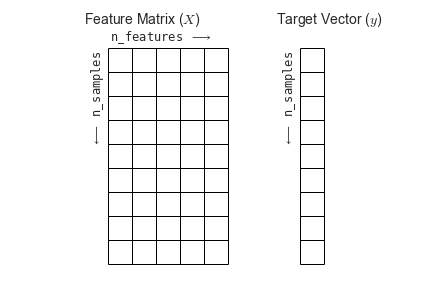

In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
### LOAD DATA ###

label = pd.read_csv('Dados\profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = ['Dados\TS1.txt','Dados\TS2.txt','Dados\TS3.txt','Dados\TS4.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)    

print(df.shape)
df.head()

(8820, 60)


C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\2096077430.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\2096077430.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\2096077430.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\2096077430.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(read_df)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391


In [3]:
n=int(len(df)/len(data))
m=len(df.columns)
print(n,'measurement cycles')
print(m,'measurements per cycle')
print(len(data),'temperature sensors')

2205 measurement cycles
60 measurements per cycle
4 temperature sensors


In [4]:
df.isnull().sum().sum()

0

In [5]:
# Data Analysis
print(f"Null = {df.columns[df.isnull().any()].tolist()}")
print(f"Na = {df.columns[df.isna().any()].tolist()}")
print(f"Duplicates = {df.duplicated().any()}")

Null = []
Na = []
Duplicates = False


In [6]:
df.duplicated().sum()

0

In [7]:
df1 = df.sort_index()
df1

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
0,40.961,40.949,40.965,40.922,40.879,40.879,40.828,40.812,40.809,40.785,...,41.211,41.129,41.195,41.211,41.207,41.191,41.207,41.207,41.129,41.250
0,38.320,38.332,38.320,38.324,38.332,38.324,38.348,38.332,38.336,38.316,...,38.523,38.539,38.578,38.531,38.523,38.566,38.613,38.590,38.578,38.594
0,30.363,30.375,30.367,30.367,30.379,30.379,30.367,30.367,30.375,30.473,...,33.180,33.172,33.363,33.340,33.324,33.410,33.504,33.582,33.594,33.555
1,41.258,41.277,41.262,41.223,41.211,41.176,41.129,41.129,41.070,41.031,...,41.949,41.941,41.980,41.957,41.980,42.020,42.023,42.031,42.078,42.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,35.449,35.359,35.277,35.184,35.195,35.184,35.105,35.016,35.012,35.008,...,35.437,35.531,35.426,35.516,35.422,35.441,35.461,35.414,35.426,35.441
2204,40.840,40.895,40.883,40.867,40.840,40.816,40.816,40.812,40.812,40.789,...,40.934,40.879,40.918,40.937,40.895,40.910,40.895,40.883,40.879,40.891
2204,35.422,35.336,35.250,35.176,35.195,35.094,35.102,35.094,35.012,35.012,...,35.437,35.453,35.520,35.437,35.437,35.441,35.437,35.434,35.434,35.426
2204,38.184,38.187,38.187,38.176,38.184,38.176,38.184,38.184,38.187,38.148,...,38.195,38.195,38.195,38.184,38.195,38.195,38.184,38.184,38.184,38.187


For plotting, we need the data in the following format: (number of measurement cycles x number of measurements per cycle x number of sensors) = (2205 x 60 x 4)

In [8]:
df1 = df.sort_index().values.reshape(-1,len(data),len(df.columns))
df1.shape

(2205, 4, 60)

In [9]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 60, 4)

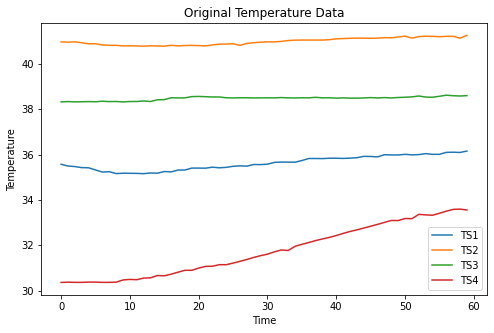

In [10]:
### PLOT ORIGINAL TEMPERATURE DATA ###
# Measurements of the 4 sensors of the first measurement cycle

plt.figure(figsize=(8,5))
plt.plot(df[0])
plt.title('Original Temperature Data')
plt.ylabel('Temperature'); plt.xlabel('Time')
plt.legend(['TS1','TS2','TS3','TS4'])
np.set_printoptions(False)

In [12]:
### LABEL DISTRIBUTION ### We only want to consider the cooler conditions
# Cooler condition / %:
#   3: close to total failure
#  20: reduced effifiency
# 100: full efficiency

label = label.Cooler
label.value_counts()

100    741
3      732
20     732
Name: Cooler, dtype: int64

In [13]:
label.unique()

array([  3,  20, 100], dtype=int64)

In [14]:
for i,j in enumerate(label.unique()):
    print(i,j)

0 3
1 20
2 100


In [15]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = label.astype("category")

{3: 0, 20: 1, 100: 2}
{0: 3, 1: 20, 2: 100}


## Extract Features with the tsfresh package

For applying the tsfresh package, we need two columns specifying the ids (measurement cycle number) and the times (time points of each measurement cycle).

In [16]:
df2=pd.DataFrame(df.reshape(-1,4))
df2

,0,1,2,3
0,35.570,40.961,38.320,30.363
1,35.492,40.949,38.332,30.375
2,35.469,40.965,38.320,30.367
3,35.422,40.922,38.324,30.367
4,35.414,40.879,38.332,30.379
...,...,...,...,...
132295,40.910,35.441,38.195,30.395
132296,40.895,35.437,38.184,30.391
132297,40.883,35.434,38.184,30.395
132298,40.879,35.434,38.184,30.402


In [17]:
tmp=pd.DataFrame()
for i in range(n):
    tmp=tmp.append(pd.DataFrame(np.arange(m)))
tmp[55:65]

C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\4011915023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp=tmp.append(pd.DataFrame(np.arange(m)))
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\4011915023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp=tmp.append(pd.DataFrame(np.arange(m)))
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\4011915023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp=tmp.append(pd.DataFrame(np.arange(m)))
C:\Users\Djonathan Quadras\AppData\Local\Temp\ipykernel_19028\4011915023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp=tmp.append(

,0
55,55
56,56
57,57
58,58
59,59
0,0
1,1
2,2
3,3
4,4


In [18]:
df2['time']=tmp.values
df2

,0,1,2,3,time
0,35.570,40.961,38.320,30.363,0
1,35.492,40.949,38.332,30.375,1
2,35.469,40.965,38.320,30.367,2
3,35.422,40.922,38.324,30.367,3
4,35.414,40.879,38.332,30.379,4
...,...,...,...,...,...
132295,40.910,35.441,38.195,30.395,55
132296,40.895,35.437,38.184,30.391,56
132297,40.883,35.434,38.184,30.395,57
132298,40.879,35.434,38.184,30.402,58


In [19]:
df2['id']=np.repeat(range(n),m)
df2

,0,1,2,3,time,id
0,35.570,40.961,38.320,30.363,0,0
1,35.492,40.949,38.332,30.375,1,0
2,35.469,40.965,38.320,30.367,2,0
3,35.422,40.922,38.324,30.367,3,0
4,35.414,40.879,38.332,30.379,4,0
...,...,...,...,...,...,...
132295,40.910,35.441,38.195,30.395,55,2204
132296,40.895,35.437,38.184,30.391,56,2204
132297,40.883,35.434,38.184,30.395,57,2204
132298,40.879,35.434,38.184,30.402,58,2204


In [20]:
df2.head(66)

,0,1,2,3,time,id
0,35.570,40.961,38.320,30.363,0,0
1,35.492,40.949,38.332,30.375,1,0
2,35.469,40.965,38.320,30.367,2,0
3,35.422,40.922,38.324,30.367,3,0
4,35.414,40.879,38.332,30.379,4,0
...,...,...,...,...,...,...
61,41.277,38.672,33.723,36.094,1,1
62,41.262,38.668,33.723,35.992,2,1
63,41.223,38.668,33.734,36.008,3,1
64,41.211,38.742,33.754,35.992,4,1


In [21]:
from tsfresh import extract_features
extracted_features = extract_features(df2, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [02:55<00:00,  8.77s/it]


In [22]:
extracted_features.shape

(2205, 3156)

In [23]:
extracted_features.iloc[:,1:10]

,1__has_duplicate_max,1__has_duplicate_min,1__has_duplicate,1__sum_values,1__abs_energy,1__mean_abs_change,1__mean_change,1__mean_second_derivative_central,1__median
0,0.0,1.0,1.0,2458.726,100756.963784,0.023339,0.004898,0.001147,40.9630
1,0.0,1.0,1.0,2338.738,91163.437296,0.023898,0.009661,0.000207,38.9845
2,0.0,0.0,1.0,2138.769,76243.976471,0.023966,0.017085,-0.000241,35.6350
3,0.0,1.0,1.0,2424.203,97950.809961,0.035017,0.014169,0.000336,40.3420
4,1.0,0.0,1.0,2388.235,95078.017793,0.048983,0.015763,0.000034,39.9670
...,...,...,...,...,...,...,...,...,...
2200,0.0,1.0,1.0,2296.156,87872.465456,0.016153,-0.001339,0.000026,38.2620
2201,1.0,0.0,1.0,2452.133,100216.237257,0.020492,-0.000322,0.000233,40.8710
2202,1.0,1.0,1.0,1825.575,55545.523021,0.015322,0.000068,-0.000871,30.4060
2203,1.0,0.0,1.0,1824.857,55501.806319,0.011153,-0.000068,-0.000164,30.4020


In [24]:
extracted_features.columns

Index(['1__variance_larger_than_standard_deviation', '1__has_duplicate_max',
       '1__has_duplicate_min', '1__has_duplicate', '1__sum_values',
       '1__abs_energy', '1__mean_abs_change', '1__mean_change',
       '1__mean_second_derivative_central', '1__median',
       ...
       '0__permutation_entropy__dimension_6__tau_1',
       '0__permutation_entropy__dimension_7__tau_1',
       '0__query_similarity_count__query_None__threshold_0.0',
       '0__matrix_profile__feature_"min"__threshold_0.98',
       '0__matrix_profile__feature_"max"__threshold_0.98',
       '0__matrix_profile__feature_"mean"__threshold_0.98',
       '0__matrix_profile__feature_"median"__threshold_0.98',
       '0__matrix_profile__feature_"25"__threshold_0.98',
       '0__matrix_profile__feature_"75"__threshold_0.98',
       '0__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=3156)

In [25]:
extracted_features.shape

(2205, 3156)

In [26]:
pd.isna(extracted_features).sum().sum()

2521037

In [27]:
#drop NaN-values
extracted_features=extracted_features.dropna(axis='columns')

In [28]:
pd.isna(extracted_features).sum().sum()

0

In [29]:
extracted_features.shape

(2205, 1996)

In [30]:
# find infinite values and set them to NaN
extracted_features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [31]:
pd.isna(extracted_features).sum().sum()

6

In [32]:
# drop NaN values
extracted_features=extracted_features.dropna(axis='columns')

In [33]:
pd.isna(extracted_features).sum().sum()

0

In [34]:
extracted_features.shape

(2205, 1994)

In [35]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, random_state = 1, test_size=0.2)

In [36]:
y_train.shape

(1764,)

In [37]:
X_train.shape

(1764, 1994)

In [38]:
y_test.shape

(441,)

In [39]:
X_test.shape

(441, 1994)

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

    z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [40]:
### SCALE DATA ###

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MODEL

### Decision Tree

In [41]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [42]:
confusion_matrix(y_test,y_pred)

array([[141,   5,   0],
       [  2, 154,   0],
       [  0,   3, 136]], dtype=int64)

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9773242630385488

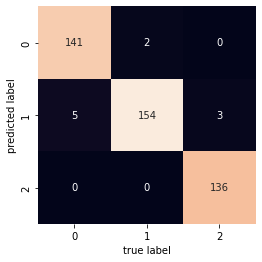

In [44]:
import seaborn as sns
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Naive Bayes 

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred2 = gnb.fit(X_train, y_train).predict(X_test)

In [46]:
confusion_matrix(y_test,y_pred2)

array([[140,   6,   0],
       [  5, 150,   1],
       [  1,   0, 138]], dtype=int64)

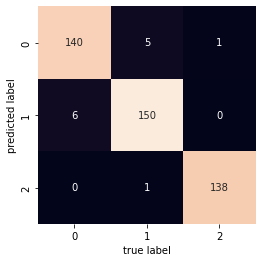

In [47]:
mat = confusion_matrix(y_test, y_pred2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [48]:
accuracy_score(y_test, y_pred2)

0.9705215419501134

### Random Forest 

In [49]:
from sklearn.ensemble import RandomForestClassifier
clfrf = RandomForestClassifier(n_estimators=20)
y_pred3 = clfrf.fit(X_train,y_train).predict(X_test)

In [50]:
confusion_matrix(y_test,y_pred3)

array([[146,   0,   0],
       [  2, 154,   0],
       [  0,   2, 137]], dtype=int64)

In [51]:
accuracy_score(y_test, y_pred3)

0.9909297052154195